# Files necessay to run:

- `PhotoReceptorData.pkl` contains the data describing the photoisomerization rates of the photoreceptors
- `IlluminationDataMEA2.pkl` contains the data describing the illumination of the LEDs
- `cal_with_MEA2_matias.pkl` contains the data describing the (human) white LED and other parameters for voltages computation

In [1]:
# prevents warnings from being printed only in this cell
import warnings
warnings.filterwarnings("ignore")
import pickle

from matplotlib.pyplot import *
from scipy import interpolate

%pylab inline
warnings.filterwarnings("default")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_obj(name ):
    if name[-4:]=='.pkl':
        name = name[:-4]
    #~ try:
        #~ return pk5.dumps(name+'pkl', protocol=5)
    #~ except:
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)
def save_obj(obj, name ):
    if name[-4:]=='.pkl':
        name = name[:-4]
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# Load Opsin data

In [3]:
fsave = './PhotoReceptorData'
PhData = load_obj(fsave)                        # Photo Receptors Data

Opsins=[]                                       # Opsins matrix initialization

Opsins.append(PhData['Scones'])                 # S cones
Opsins.append(PhData['Mela'])                   # Melanopsin
Opsins.append(PhData['Rods'])                   # Rods
Opsins.append(PhData['Mcones'])                 # M cones
Opsins.append(PhData['RedOpsin'])               # Red Opsin

x = PhData['x_axis']                            # Wavelength axis

# Creating a dictionary with indexes for each opsin
OpsinIndex = {'S-cone':0,'Melano':1,'Rhodo':2,'M-cone':3,'Redo':4}


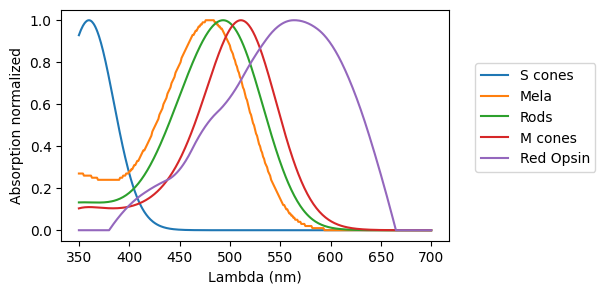

In [4]:
fig, ax = plt.subplots(figsize=(5, 3))

for o in Opsins:
    ax.plot(x,o)

ax.set_xlabel('Lambda (nm)')    
ax.set_ylabel('Absorption normalized')

# move legend out of the plot
ax.legend(['S cones','Mela','Rods','M cones','Red Opsin'], bbox_to_anchor=(1.05, 0.8))


# Load LEDs illumination Data

In [5]:
fsave = './IlluminationDataMEA2'
IData = load_obj(fsave)                                     # Illumination Data Load

LEDs =[]                                                    # LEDs matrix initialization                                
LEDs.append(IData['Violet'])                                # Violet        
LEDs.append(IData['Blue'])                                  # Blue
LEDs.append(IData['Green'])                                 # Green
LEDs.append(IData['Yellow'])                                # Yellow
LEDs.append(IData['Red'])                                   # Red

x = IData['x_axis']                                         # Wavelength axis

# Power meter correction factor from 09/09/22
correction_f = 1                                        

LEDs=np.array(LEDs)/correction_f                            # Correction

Text(0, 0.5, 'Power (µW/cm²)')

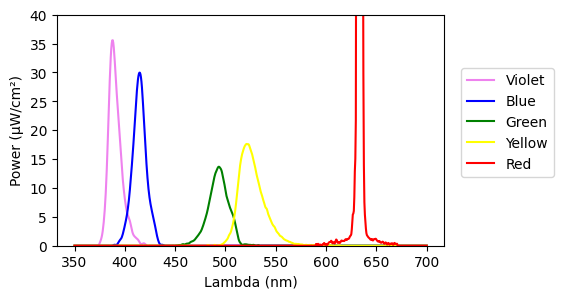

In [6]:
fig , ax = plt.subplots(figsize=(5, 3))

ax.plot(x,LEDs[0], 'violet')
ax.plot(x,LEDs[1], 'blue')
ax.plot(x,LEDs[2], 'green')
ax.plot(x,LEDs[3], 'yellow')
ax.plot(x,LEDs[4], 'red')

ax.legend(['Violet','Blue','Green','Yellow','Red'], bbox_to_anchor=(1.3, 0.8))

ax.set_ylim([0,40])
ax.set_xlabel('Lambda (nm)')
ax.set_ylabel('Power (µW/cm²)')


# Calculate Isomerizations

## Functions

In [7]:
def IlluminanceFactor(Amp1,AmpPhoto,wl):
    """""
    This function calculates the Illuminance Factor Product for a given LED source and a given target opsin.
    The Illuminance Factor Product is the product of the LED source amplitude, the target opsin spectra and the wavelength axis.

    Output is in isomerizations / s
    To get the result in photons/cm^2/s we have to multiply by 10^8 and divide by ac (x5 or x2 for rods)
    
    Parameters
    ----------
    Amp1 : numpy array
        The light (LED source) amplitude not normalized in µW/cm²
    AmpPhoto : numpy array
        The spectra of the target opsin normalized to 1 at the peak (a.u.)
    wl : numpy array
        The wavelength axis (nm)
    
    Returns
    -------
    IlluminanceFactor : numpy array
        The isomerizations / s

    Factors have units of:
    ----------------------
    ac = µm²
    hc = J.m
    10**23 puts all in µW - µm² 
    """""
    #Illuminance Factor Product hyperparameters
    h=6.63*10**(-34)                    # Planck constant J.s
    c=299792458                         # speed of light [m/s]  
    
    ac=[0.2,0.2,0.5,0.2,0.2]            # in µm²                                                                                    
    # ac_cones=0.2
    # ac_mela=0.2
    # ac_rods=0.5
    # ac_reach=0.2
    # ac_red=0.2

    IlluminanceFactor=[]
    for photo in range(len(AmpPhoto)):
        IlFa=0
        for I_wl in range(len(Amp1)):
            # Results in photoisomerisation/s /µm²
            IlFa+= Amp1[I_wl] * AmpPhoto[photo][I_wl] * wl[I_wl] * diff(wl)[10]  * ac[photo]/(h*c) *10**(-23)                                          # 10th element of diff is selected for experimental reasons
                    #µW/cm²   x   a.u.(peak at 1)    x nm (lambda) x lambda step x ph.µm² x 1/(Jm)  x convert to same units
        IlluminanceFactor.append(IlFa) 
    return np.array(IlluminanceFactor) #

def Write_fancy(result,F):
    o_names = ['Scones    ','Melanopsin','Rhodopsin ','Mcones    ','Red_opsin ']
    for i,r in enumerate(result):
        if F=='scientific':
            print(o_names[i],' :',"{:.2e}".format(r))
        else:
             print(o_names[i],' :',"{:10.0f}".format(r))

## Compute Isomerization for all opsins for all LEDs sources

In [8]:
print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM VIOLET LED')

# Get effect from Violet
VIOLET_ISO_result = IlluminanceFactor(LEDs[0],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(VIOLET_ISO_result,F=0)

# -----------------------------------------------------------------------------------------------

print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM BLUE LED')

# Get effect from Blue
BLUE_ISO_result = IlluminanceFactor(LEDs[1],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(BLUE_ISO_result,F=0)

# -----------------------------------------------------------------------------------------------

print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM GREEN LED')

# Get effect from Green
GREEN_ISO_result = IlluminanceFactor(LEDs[2],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(GREEN_ISO_result,F=0)

# -----------------------------------------------------------------------------------------------

print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM YELLOW LED')

# Get effect from Yellow
YELLOW_ISO_result = IlluminanceFactor(LEDs[3],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(YELLOW_ISO_result,F=0)

# -----------------------------------------------------------------------------------------------

print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM RED LED')

# Get effect from RED
RED_ISO_result = IlluminanceFactor(LEDs[4],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(RED_ISO_result,F=0)

print ('\n')




-----------------------------
EFFECTS FROM VIOLET LED
Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :     926469
Melanopsin  :     499454
Rhodopsin   :     761849
Mcones      :     211537
Red_opsin   :     133091


-----------------------------
EFFECTS FROM BLUE LED
Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :     207797
Melanopsin  :     772089
Rhodopsin   :    1325039
Mcones      :     282238
Red_opsin   :     348531


-----------------------------
EFFECTS FROM GREEN LED
Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :         65
Melanopsin  :    1454706
Rhodopsin   :    3854789
Mcones      :    1377817
Red_opsin   :     941918


-----------------------------
EFFECTS FROM YELLOW LED
Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :          3
Melanopsin  :    1217198
Rhodopsin   :    4458878
Mcones      :    2262678
Red_

In [9]:
# Get effect from All together

ISO_result = IlluminanceFactor(np.sum(LEDs[0:4],axis=0),Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :    1134334
Melanopsin  :    3943447
Rhodopsin   :   10400555
Mcones      :    4134269
Red_opsin   :    3611956

Scones      : 1.13e+06
Melanopsin  : 3.94e+06
Rhodopsin   : 1.04e+07
Mcones      : 4.13e+06
Red_opsin   : 3.61e+06


In [10]:
OpsinIndex

{'S-cone': 0, 'Melano': 1, 'Rhodo': 2, 'M-cone': 3, 'Redo': 4}

## Repeat for (Human) White Light Illumination


25.000000000000007

<Figure size 640x480 with 0 Axes>

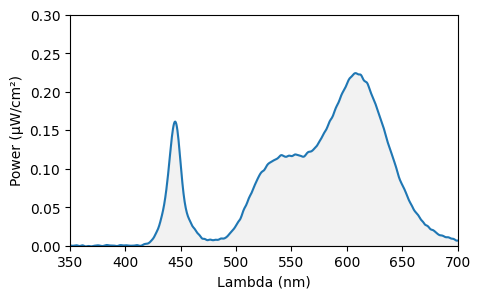

In [11]:
# Load LED data (for white in this case)
file_cal = 'cal_with_MEA2_matias.pkl'
caldata =load_obj(file_cal)

lx = caldata['xnew']
lx[0] = 300

color_order = caldata['orderS']
spec_curves = np.array(caldata['LedSpectra'])
spec_curves[:,0]=0


#--------------------------------------------------------------------------------
# White Spec for Vis Stim
figure()
WhiteVisPower = 25

WhiteVS = spec_curves[5]/np.sum(spec_curves[5])/diff(lx)[10]  * WhiteVisPower

f = interpolate.interp1d(lx,WhiteVS)
newWvis = f(x)/np.sum(f(x))*np.sum(WhiteVS)*diff(lx)[10]/diff(x)[0]

fig , ax = plt.subplots(figsize=(5, 3))

ax.plot(x,newWvis)
ax.fill_between(x,0,newWvis,alpha=0.1, color='grey')

ax.set_xlim([350,700])
ax.set_ylim([0,0.3])
ax.set_xlabel('Lambda (nm)')
ax.set_ylabel('Power (µW/cm²)')

np.sum(newWvis)*diff(x)[10]

In [12]:
# Get effect from White at Vis stim in 2p Setup

ISO_result = IlluminanceFactor(newWvis,Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :         89
Melanopsin  :      22069
Rhodopsin   :      69974
Mcones      :      33646
Red_opsin   :     102293

Scones      : 8.85e+01
Melanopsin  : 2.21e+04
Rhodopsin   : 7.00e+04
Mcones      : 3.36e+04
Red_opsin   : 1.02e+05


In [13]:
# Get effect from White at OPTO full field

WhiteOptoPower = 71900/correction_f
ISO_result = IlluminanceFactor(newWvis/np.sum(newWvis)*WhiteOptoPower/diff(x)[10],Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')

print('')
# For Chrimson activation -> photons / cm2 / s -> *10^8 /ac  (=*5)
print('For photons / cm / s')
Write_fancy(ISO_result*10**8*5,F='scientific')

Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :     254557
Melanopsin  :   63471241
Rhodopsin   :  201245534
Mcones      :   96767139
Red_opsin   :  294194753

Scones      : 2.55e+05
Melanopsin  : 6.35e+07
Rhodopsin   : 2.01e+08
Mcones      : 9.68e+07
Red_opsin   : 2.94e+08

For photons / cm / s
Scones      : 1.27e+14
Melanopsin  : 3.17e+16
Rhodopsin   : 1.01e+17
Mcones      : 4.84e+16
Red_opsin   : 1.47e+17


# Building (Mouse) White light illumination

## Computations

In [14]:
# Filippo
#----------------------------------------
violet = 1 * 0.5
blue   = 0 
green = 0
yellow = 0.316* 0.5
red    = 0


my_light = LEDs[0]*violet + LEDs[1]*blue + LEDs[2]*green + LEDs[3]*yellow + LEDs[4]*red


In [15]:
NDfilter = 0
Transmission =  10**(-NDfilter/10)

LIGHT = (violet*LEDs[0]+blue*LEDs[1]+green*LEDs[2]+yellow*LEDs[3]+red*LEDs[4])*Transmission

ISO_result = IlluminanceFactor(LIGHT,Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)

Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :     463235
Melanopsin  :     442044
Rhodopsin   :    1085427
Mcones      :     463271
Red_opsin   :     412315


In [16]:
# Load LED data
file_cal = "cal_with_MEA2_matias.pkl"
caldata =load_obj(file_cal)
print(caldata.keys())

dict_keys(['V', 'Vcurves', 'xnew', 'LedSpectra', 'orderV', 'orderS', 'whiteP'])


In [17]:
lx = caldata['xnew']
lx[0] = 300

color_order = caldata['orderS']
spec_curves = np.array(caldata['LedSpectra'])
spec_curves[:,0]=0

reorder = [1,2,3,4,5]
Vcurves = np.array(caldata['Vcurves'])[:,reorder]

In [18]:
# New interpolated V calibration curves
#---------------------------------------------

Vnew = np.linspace(0,5,5001)
newVcurves = np.zeros([5,5001])
for i in np.arange(5):
    vals = (np. isnan(Vcurves[:,i]))==False
    f = interpolate.interp1d(caldata['V'][vals],Vcurves[:,i][vals],fill_value="extrapolate")
    newVcurves[i] = f(Vnew) / correction_f  # use interpolation function returned by `interp1d`
    newVcurves[i] = np.where(newVcurves[i]<0,0,newVcurves[i]) # take negative extrapolations out


Rmax = np.nanmax(newVcurves[0])
Ymax = np.nanmax(newVcurves[1])
Gmax = np.nanmax(newVcurves[2])
Bmax = np.nanmax(newVcurves[3])
Vmax = np.nanmax(newVcurves[4])

In [19]:
# Function that returns a voltage given a certain power value in percentage of max possible value  
def find_V(value,color):
    if color =='r':
            array = newVcurves[0]
            vmax=Rmax
    elif color== 'y':
            array = newVcurves[1]
            vmax=Ymax
    elif color== 'g':
            array = newVcurves[2]
            vmax=Gmax
    elif color== 'b':
            array = newVcurves[3]
            vmax=Bmax
    elif color== 'v':
            array = newVcurves[4]
            vmax=Vmax
    
    array = np.asarray(array)
    idx = (np.abs(array - value*vmax)).argmin()
    return Vnew[idx]
#==============


# 1/violet,1/green,Transmission
#Print voltages
print('\nVoltages')
print('redV   ',find_V(red,'r'),' V')
print('yellowV',find_V(yellow,'r'),' V')
print('greenV ',find_V(green,'r'),' V')
print('blueV  ',find_V(blue,'r'),' V')
print('violetV',find_V(violet,'r'),' V')



Voltages
redV    0.0  V
yellowV 0.5660000000000001  V
greenV  0.0  V
blueV   0.0  V
violetV 1.907  V
